<a href="https://colab.research.google.com/github/rebecca-yoo/github-slideshow/blob/main/lab1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Names (Enter your names below)
**Your Name and JHED:** Rebecca Yoo, ryoo4

**Partner's Name and JHED (If applicable):**  ...

# Lab 1: Heart Rate Estimation and Signal De-noising
By **Benjamín Béjar Haro** and edited by **Kwame Kutten**

In this lab we will address the problem of heart rate estimation from noisy observations. For a healthy individual, and under ideal conditions, this task might be easy to accomplish. However, different disorders together with different sources of error cause distortions to the signal rendering the estimation task more difficult. We will study how prior information about the signal and the interference can be exploited in order to improve the estimation task under less ideal conditions.

We will start detecting the QRS-complex assuming we have a template of the underlying waveform. Later, we will move to a more realistic scenario where we will be implementing a simplified version of the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029) and we will test it on real ECG data recordings.

### Objectives
By the end of this session you should be able to understand the main challenges in the estimation of EGC signals. How to work from modeling assupmtions in order to exploit your prior knowledge in the estimation task.

***

### Task 1. Signal generation and template matching (40 points total)
In this task we will implement a simple version of a QRS-complex detector by using template matching, thresholding and non-maximum suppresion on the
observed ECG signal. We will then use those detections to provide an estimate of the heart rate.

* **Task 1A: Signal Generation (15 points) -** We are going to create a synthetic EGC signal that we will be using to test our detector algorithm. For that purpose generate a stream of $K = 10$ equally spaced pulses over a time span of $10\ s$.  Each pulse should have a sampling rate of $f_s = 256\ Hz$. The goal of this task is to create a basic model for a ECG signal. You can think of the signal as the convolution of a canonical pulse shape $\varphi(t)$ with a stream of Dirac delta functions: 

   $$x(t) = \sum_{k=1}^K a_k\, \varphi(t-t_k) = \varphi(t) \ast \sum_{k=1}^K a_k\, \delta(t-t_k),$$ 

   where $K$ is the number of pulses observed, $a_k$ represent the amplitudes of the different pulses and $t_k$ correspond to the locations of the pulses in time. For the purpose of this task use the canonical pulse shape generated by the `ecg_wave()` function defined in the notebook and constant unit amplitudes $a_k=1$. Plot the generated signal over time adding the appropriate labels for the axis.


Text(0, 0.5, 'Signal')

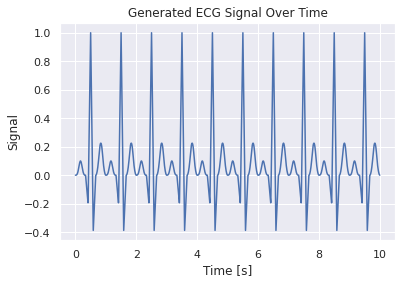

In [338]:
# ============================================================================
# import modules
# ============================================================================
# Note that this part of the code needs to be run prior to any other code cell

import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal

# inline plots
%matplotlib inline
sns.set()

# ============================================================================
# functions
# ============================================================================
def ecg_wave(x):
    """
    This function generates a single synthetic ECG template of unit length (support).
    For example, for a sampling frequency of f_s, use x = np.linspace(0,1, f_s, endpoint=False)
    """
    
    # compute signal (superposition of splines)
    return 0.3 * signal.bspline(3*3*x-7.5,2)\
         + 0.15* signal.bspline(3*4*x-2,3)\
         + signal.bspline(3*2*2*x-6,1) - 0.2 * signal.bspline(3*4*x-5,1) - 0.4 * signal.bspline(3*4*x-7,1)


# ============================================================================
# Write Your code here
# ============================================================================
x_1 = np.linspace(0, 1, 256, endpoint=False)
ecg_wave_1 = ecg_wave(x_1)
signal_list = []
tsl = np.linspace(0, 10, num = 2560, endpoint=False)
for i in np.arange(1,11):
  for j in np.arange(256):
    signal_list.append(ecg_wave_1[j,])
plt.figure()
plt.plot(tsl, signal_list)
plt.title('Generated ECG Signal Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Signal')



* **Task 1B: Simulate Noise (5 points)-** Generate a noisy version of the synthetic ECG signal generated by adding Gaussian noise with standard deviation $\sigma=0.5$. Plot the noisy observations.

Text(0, 0.5, 'Signal')

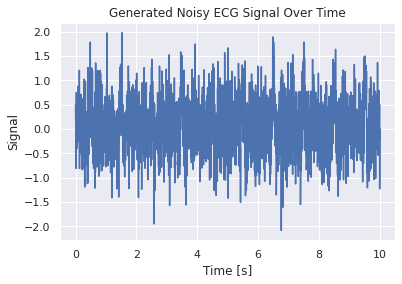

In [339]:
# ============================================================================
# Write Your code here
# ============================================================================    
# generate noise
n = np.random.normal(0, 0.5, 2560)
noisy_s = signal_list+n
    
# return noisy signal
plt.figure()
plt.plot(tsl, noisy_s)
plt.title('Generated Noisy ECG Signal Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Signal')


* **Task 1C: Find Peaks (10 points) -** Implement a QRS-complex detector on the noisy signal you just generated. For that purpose we will use template matching, thresholding, and non-maximum suppression. First you should implement template matching by correlating the noisy signal with a template ECG pulse using `np.correlate`.   We recommend that you normalize the signal to range $[0,1]$ using `noralize_range` before thresholding. Then plot the result. Next choose a threshold value and keep only those values of the signal that are above the given threshold. Once you have done that, perform a non-maximum suppression (i.e., keep a value if it is greater than the previous and following values). To implement the thresholding and non-maximum suppression operations you can use `signal.find_peaks` function with the `height` parameter set to the your chosen threshold.  Print the times of each peak in seconds.

The times of each peak in the signal are listed
0.48828125 seconds
1.48828125 seconds
2.5 seconds
3.49609375 seconds
4.5 seconds
5.48828125 seconds
6.5078125 seconds
7.48828125 seconds
8.49609375 seconds
9.50390625 seconds


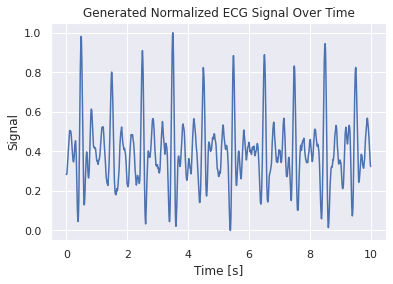

In [340]:
def normalize_range(x):
    """
    Normalizes the signal such that its minimum value is 0 and its maximum value is 1,
    provided the signal is not identically zero.
    """
    # check that there are non-zero elements
    if np.any(x):
        
        # subtract minimum
        minx = np.min(x)
        z = x - minx
        
        # divide by max value
        maxz = np.max(z)
        return z/maxz
    
    else:    
        return x
    
# ============================================================================
# Write Your code here
# ============================================================================
corr_s = np.correlate(ecg_wave_1, noisy_s, mode = 'same')
corr_s_n = normalize_range(corr_s)
plt.figure()
plt.plot(tsl, corr_s_n)
plt.title('Generated Normalized ECG Signal Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
non_max_thresh,_ = signal.find_peaks(corr_s_n, height = 0.71)
# plt.plot(tsl[non_max_thresh], corr_s_n[non_max_thresh], 'o')
print("The times of each peak in the signal are listed")
for i in non_max_thresh:
  print(str(i/256) + " seconds")


* **Task 1D: RR Intervals (10 Points)** Plot the original (synthetic) ECG signal as well as the locations of the peaks to verify your method. Keep in mind to compensate for any delay you might have introduced by filtering. From the peak binary signal, estimate the $RR$ interval sequence $r_n$ and its average value as:

$$ \bar R = \frac{1}{N}\sum_{n=0}^N r_n, $$

where $N$ is the number intervals between peaks. Provide an estimate of the average heart beat rate in beats per minute $[bpm]$.


The Average Heart Rate is Estimate to be 59.89601386481802 beats per minute.


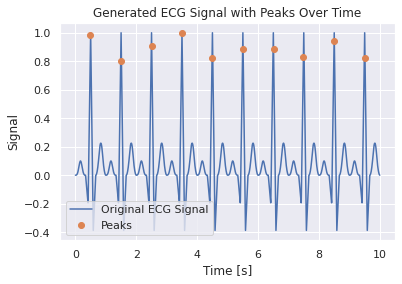

In [341]:
# ============================================================================
# Write your code here
# ============================================================================
plt.plot(tsl, signal_list, label = 'Original ECG Signal')
plt.plot(tsl[non_max_thresh], corr_s_n[non_max_thresh], 'o', label = 'Peaks')
plt.title('Generated ECG Signal with Peaks Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
plt.legend(loc = 'lower left')
rr = np.mean(np.diff(non_max_thresh)/256)
print("The Average Heart Rate is Estimate to be " + str(60/rr) + " beats per minute.")




### Task 2. QRS complex detection via Pan-Tompkins algorithm (60 points total)
Now let us consider a more realistic scenario where we have a noisy ECG signal and the waveform of the QRS-complex is unknown. There are different sources of noise that can be present during an ECG acquisition. In addition to high-frequency thermal noise, it is also common to observe the presence of low-frequency interference coming from breathing. 
When it comes to pathologies, different non-additive distortions might be present on the ECG signal 
that alter the shape of the QRS-complex itself but for the purpose of this task we just assume a healthy  individual where signal distortion comes solely from the acquisition process. The procedure that we will employ in order to estimate the locations of the QRS-complex is based on the Pan-Tompkins algorithm [Pan-Tompkins algorithm](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=4122029).

**Important Note 1:** You may need to **adjust the `path` variable below.**

**Important Note 2:** If you are using **Google Colab you must follow these steps**

1. Upload **ecg_mitnst.json** into your Google Drive.  If you placed it in a sub folder called **lab1** the use `path = "gdrive/My Drive/lab1/"`. Otherwise use `path = "gdrive/My Drive/"`
2. Run the folloing cell and follow instructions to obtain the authorization key

In [ ]:
# ============================================================================
# Edit path variable below if necessary
# ============================================================================

try:
    # Executes if running in Google Colab
    from google.colab import drive
    drive.mount('gdrive/')
    path = 'gdrive/My Drive/ecg_mitnst.json' # Change path to location of data
except:
    # Executes if running locally (e.g. Anaconda)
    path = 'ecg_mitnst.json' # Change path to location of data

with open(path,'r') as infile: data = json.load(infile)

# print data to see dictionary fields
print(data.keys())

Drive already mounted at gdrive/; to attempt to forcibly remount, call drive.mount("gdrive/", force_remount=True).
dict_keys(['fs', 'time', 'tk', 'voltage'])


**Task 2A: Effect of noise (10 points):** Load the signal **ecg_mitnst.json**  You may have to change `path` to point to the correct loation where you downloaded **ecg_mitnst.json**. The loaded `data` dictionary will contain four fields.  `fs` is the sampling frequency, `voltage` is the measured voltage in *mV* at corresponding `time` points and `t_k` contains the indices of the peaks.  Plot the voltage over time with the given peaks. The signal corresponds to a sample ECG from the [MIT noise stress dataset](https://physionet.org/physiobank/database/nstdb/)
that has been downloaded from [physionet.org](https://physionet.org/physiobank/database/).
Plot the signal and observe the presence of a strong low-frequency component.

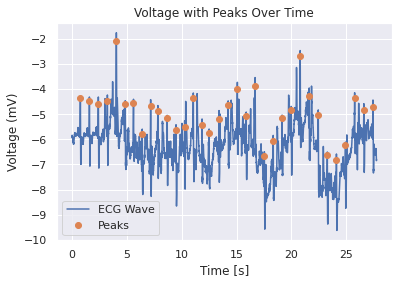

In [343]:
# ============================================================================
# Write your code here
# ============================================================================
time = data['time']
voltage = data['voltage']
t_k = data['tk']
fs = data['fs']
t_s = []
v_s = []
for i in t_k:
  t_s.append(time[i])
  v_s.append(voltage[i])
plt.figure()
plt.plot(time, voltage, label = 'ECG Wave')
plt.plot(t_s, v_s, 'o', label = 'Peaks')
plt.title('ECG Signal with Peaks Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')
plt.legend()


#### **Pan-Tompkins Algorithm**
In order to deal with noise we will implement a simplified version of the Pan-Tompkins algorithm. For that purpose proceed as follows:

**Task 2B (10 points):** _Bandpass filtering:_ . In this first step we want to eliminate as much as possible interference that is present in our acquired signal. In order to do that we can filter the signal and only leave the frequency range
that is of interest for our task (e.g. $5-15$ Hz as suggested in the original Pan-Tompkins paper) the bandpass filtering operation as the concatenation of a lowpass and a highpass filtering steps:

* _Highpass filtering:_ A highpass filter can be thought of as removing the lower frequency component of the signal. That means that we could use a lowpass filter to get a lowpass version of the original signal and then subtract the result from the original series. We will use a lowpass filter of triangular shape and length $L$. Determine the length of the filter based on the required passband (i.e. the filter should attenuate significantly beyond $5$ Hz) or empirically by adjusting the value of $L$. Plot the original signal together with the lowpass filtered version. The latter one should describe the trend in the ECG recording. Remember to normalize the filters (i.e., weights add up to one) to prevent signal amplification or attenuation. In an additional plot also display the signal with the lowpass version removed (high-pass filtered).

* _Lowpass filtering:_ Use an averaging (box) filter to reduce high-frequency noise. Filter the signal with a filter of length $L=10$ taps.

For your convinence we have provided `boxFilter` and `triangleFilter` functions.

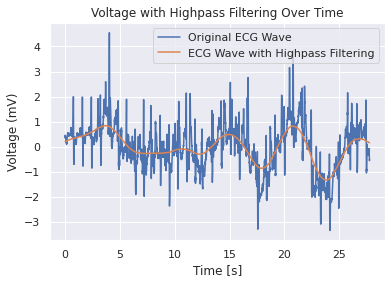

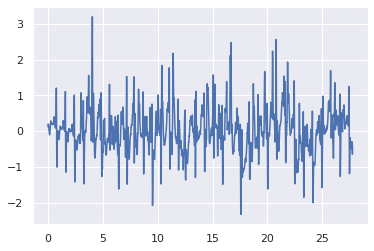

In [344]:
def boxFilter(L):
    """
    Genearte box filter of length L
    """
    h = np.ones(L)
    return h/np.sum(h)

def triangleFilter(L):
    """
    Generate triangle filter of length L
    """
    h = np.convolve(boxFilter(L//2), boxFilter(L//2))
    h = np.concatenate(([0],h))
    if L % 2: h = np.concatenate((h,[0]))
    return h/np.sum(h)

# ============================================================================
# Write your code here
# ============================================================================
L = 360*4
low_filter = triangleFilter(L)
voltage = voltage - np.mean(voltage)
low_fil_vol = np.convolve(low_filter, voltage, mode = 'same')
plt.figure()
plt.plot(time, voltage, label = 'Original ECG Wave')
plt.plot(time, low_fil_vol, label = 'ECG Wave with Highpass Filtering')
plt.title('ECG Signal with Highpass Filtering Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')
plt.legend()

high_filter = boxFilter(10)
high_fil_vol = np.convolve(high_filter, voltage-low_fil_vol, mode = 'same')
plt.figure()
plt.plot(time, high_fil_vol)
plt.title('ECG Signal with Lowpass Filtering Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')



**Task 2C (10 points):** _Differentiation:_ Differentiate the resulting signal in order to localize the region ofsteepest  slope  in  the  QRS-complex.   You  can  use  the  finite  difference  filter. You can use the finite difference filter: 

$$d_n = \frac{1}{8}\big(\delta_{n-2} + 2\delta_{n-1} -2\delta_{n+1} - \delta_{n+2}\big)$$

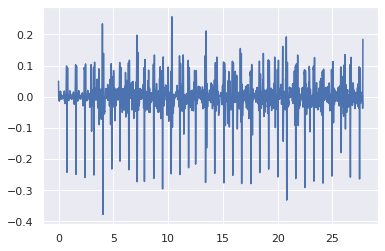

In [345]:
from numpy.core.arrayprint import StructuredVoidFormat
# ============================================================================
# Write your code here
# ============================================================================
'''
dn is a filter and you use differentiation by using convolution to find the StructuredVoidFormat
Find an array that looks like 1/8 * [1,2,0,-2,-1]
dn 
'''
dn = [1/8, 1/4, 0, -1/4, -1/8]
fil_sig = np.convolve(dn, high_fil_vol, mode = 'same')
plt.plot(time, fil_sig)
plt.title('Differentiated ECG Signal with Bandpass Filtering Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')




**Task 2D (10 points):** _Signal squaring:_ Square the obtained signal after differentiation and plot the obtained waveform.

Text(0, 0.5, 'Voltage [mV]')

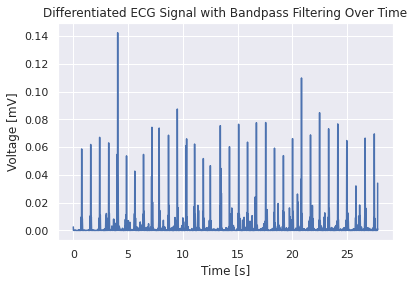

In [348]:
# ============================================================================
# Write your code here
# ============================================================================
fil_sig_sqrd = fil_sig**2
plt.plot(time, fil_sig_sqrd)
plt.title('Differentiated ECG Signal with Bandpass Filtering Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')

**Task 2E (10 points):** _Integration:_ Integrate the resulting signal from the squaring operation with a box window of length $L=50$. Display the resulting signal

Text(0, 0.5, 'Voltage [mV]')

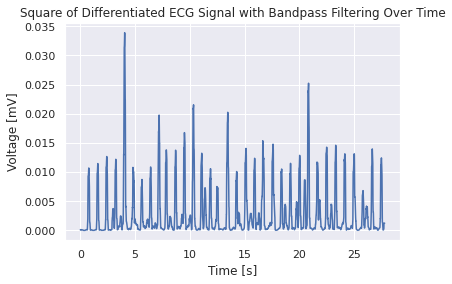

In [349]:
# ============================================================================
# Write your code here
# ============================================================================
integ_filter = boxFilter(50)
integral_fil = np.convolve(integ_filter, fil_sig_sqrd, mode = 'same')
plt.figure()
plt.plot(time, integral_fil)
plt.title('Integral of ECG Signal with Bandpass Filtering Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Voltage [mV]')

**Task 2F (10 points):** _Peak detection:_ Use a peak detector to estimate the locations of the peaks add them to the previous plot. Estimate the sequence of **RR** intervals and plot the corresponding heart beat rate over time.

In [1]:
# ============================================================================
# Write your code here
# ============================================================================
plt.figure()
plt.plot(time, integral_fil, label = 'Integrated ECG Signal')
plt.title('Integral of ECG Signal Over Time')
plt.xlabel('Time [s]')
plt.ylabel('Signal')
(non_max_thresh_1,_) = signal.find_peaks(integral_fil, height = 0.0075, distance = 200)
time = np.array(time)
time_numpy = time[non_max_thresh_1]
time_numpy = time_numpy[1:]
plt.plot(time[non_max_thresh_1], integral_fil[non_max_thresh_1], 'o', label = 'Peaks')
plt.figure()
plt.step(time_numpy, 60/np.diff(time[non_max_thresh_1]))
plt.title('Heart Rate Over Time in RR Intervals')
plt.xlabel('Time [s]')
plt.ylabel('Heart Rate [bpm]')

NameError: ignored